In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,774 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,057 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:

In [ ]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType

# Create a SparkSession
spark = SparkSession.builder.appName("Diabetes").getOrCreate()

In [ ]:
# Read in data
from pyspark import SparkFiles
url="https://diabetesdataprediction.s3.ca-central-1.amazonaws.com/diabetes.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("diabetes.csv"), header=True, inferSchema=True, quote="\"", escape="\"")
# Show DataFrame
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [ ]:
df = df.filter((df.Glucose != 0) & (df.BloodPressure != 0) & (df.SkinThickness != 0) & (df.Insulin != 0) & (df.BMI != 0))
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|
|          2|    197|           70|           45|    543|30.5|                   0.158| 53|      1|
|          1|    189|           60|           23|    846|30.1|                   0.398| 59|      1|
|          5|    166|           72|           19|    175|25.8|                   0.587| 51|      1|
|          0|    118|           84|           47|    230|45.8|                   0.551| 31|      1|


In [ ]:
#Create a temporary view.
df.createOrReplaceTempView('Diabetes')

In [ ]:
#Identify how many positive and negative diabetic results are in the dataset
result = spark.sql("SELECT COUNT(*) AS number FROM Diabetes GROUP BY Outcome ORDER BY Outcome")
result.toPandas()

,number
0,262
1,130


In [ ]:
result = spark.sql("SELECT Outcome, AVG(SkinThickness), AVG(Insulin), AVG(Glucose), AVG(BloodPressure), AVG(BMI) FROM Diabetes GROUP BY Outcome")
result.toPandas()

,Outcome,avg(SkinThickness),avg(Insulin),avg(Glucose),avg(BloodPressure),avg(BMI)
0,1,32.961538,206.846154,145.192308,74.076923,35.777692
1,0,27.251908,130.854962,111.431298,68.969466,31.750763


In [ ]:
Diabetes_df = df.toPandas()

<Axes: >

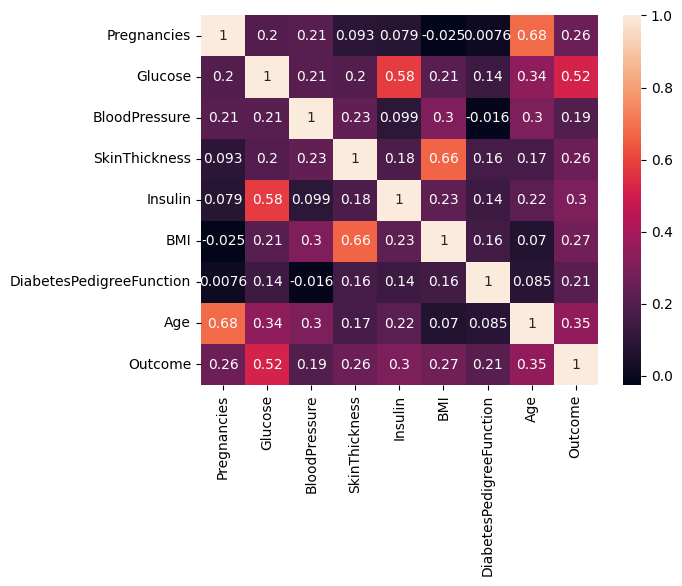

In [ ]:
import seaborn as sns
sns.heatmap(Diabetes_df.corr(), annot = True)

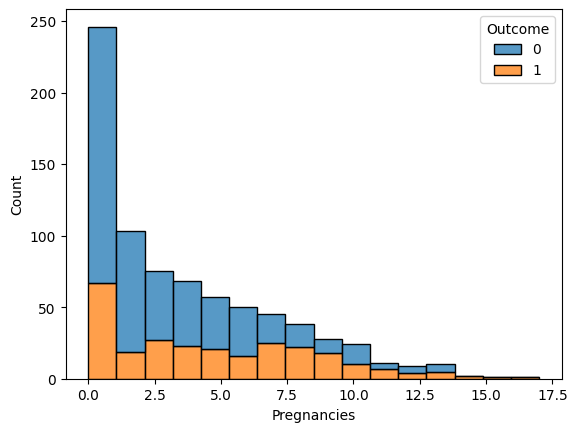

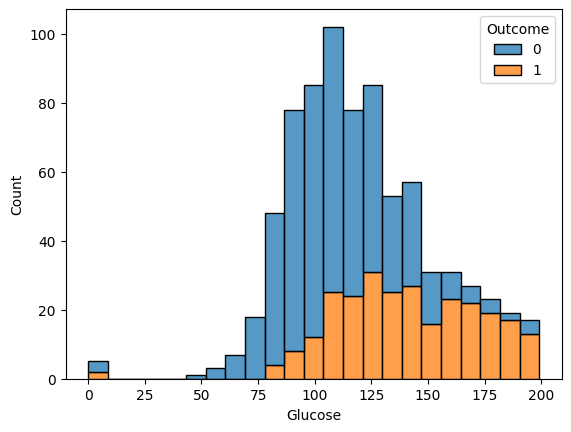

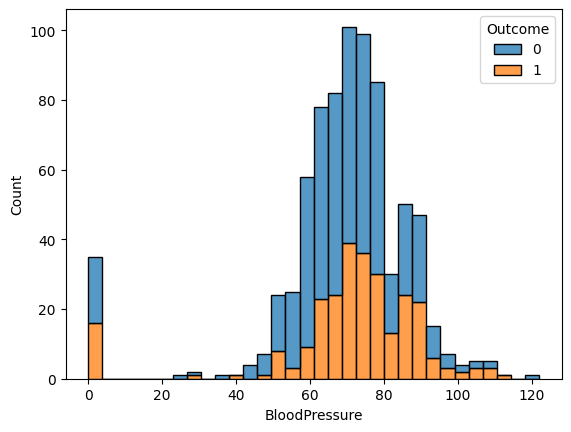

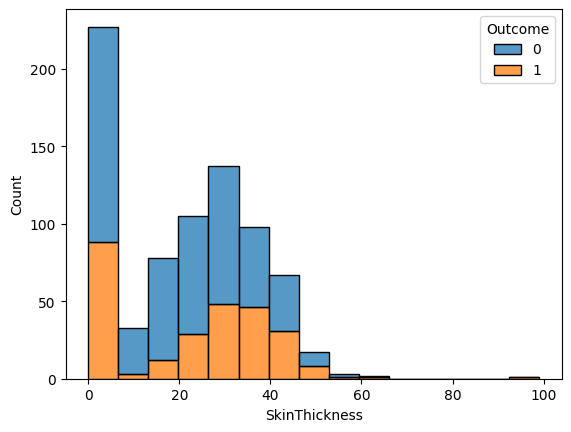

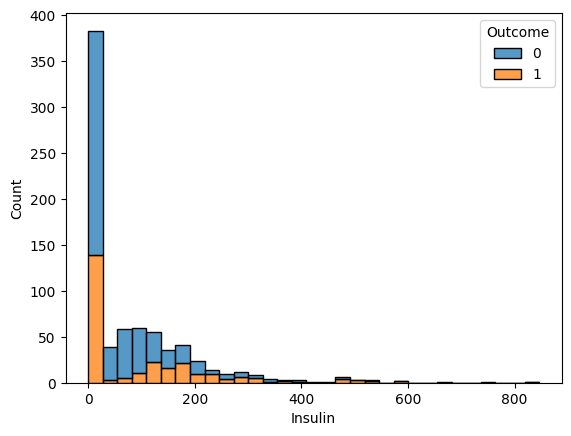

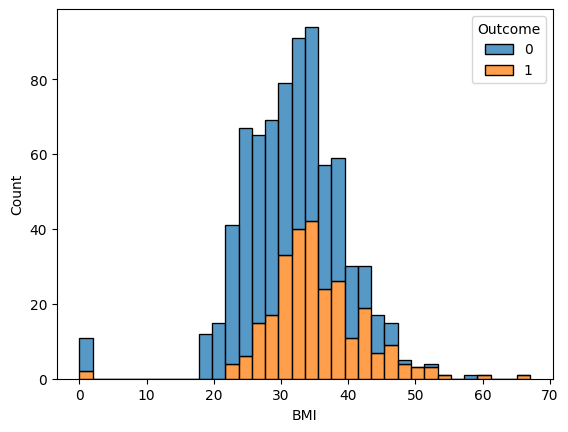

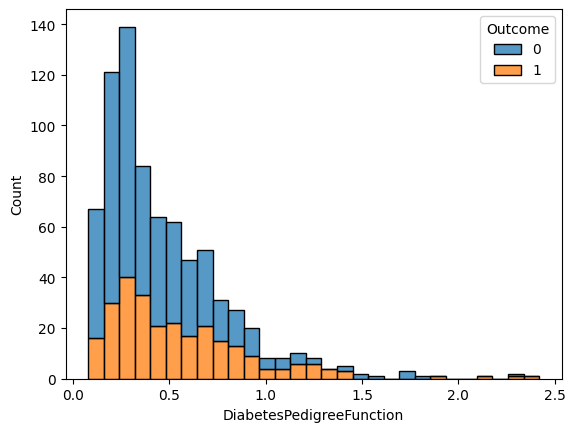

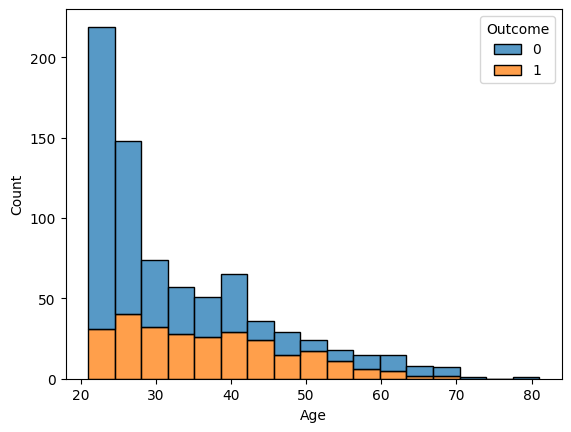

In [ ]:
import matplotlib.pyplot as plt
cols=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
for i in cols:
  sns.histplot(x = i, hue = "Outcome", data = Diabetes_df, multiple = "stack")
  plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#segregate the dependent and independent variable
X = Diabetes_df.drop(columns = ['Outcome'])
y = Diabetes_df['Outcome']

In [ ]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
X_train.shape, X_test.shape

((294, 8), (98, 8))

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = LogisticRegression()

model.fit(X_train_scaled,y_train)

LogisticRegression()

In [ ]:
# Print the balanced_accuracy score of the model
# YOUR CODE HERE!
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report,accuracy_score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_train, model.predict(X_train_scaled))}")

Balanced Accuracy Score: 0.7456695797791617
